In [ ]:
using Pkg
Pkg.activate("../Project.toml")
Pkg.instantiate()

In [2]:
#45s
#using Distributed
using Dates
using Plots
using JLD2
using LsqFit, StatsBase
using QuadGK
using Parameters
using Distributions
using SpecialFunctions
using Random
using SparseArrays
using MultivariateStats


include(joinpath(@__DIR__,"..","src","Parameter_Setting.jl"))
include(joinpath(@__DIR__,"..","src","Dynamics.jl"))
include(joinpath(@__DIR__,"..","src","reversal_learning.jl"))
include(joinpath(@__DIR__,"..","src","Babadi_Formula.jl"))
include(joinpath(@__DIR__,"..","src","Plot.jl"))

cent(X) = X .- mean(X,dims=1)
corr(X,N) = ((X' * X) / N) ./ sqrt.(diag(X'*X/N) * diag(X' * X/N)')
cov(X,N) = ((X' * X) / N)# ./ sqrt.(diag(X'*X/N) * diag(X' * X/N)')
palette_J = cgrad(:Blues,6,categorical=true)
palette_h = cgrad(:Oranges,6,categorical=true)
tmp_correlation_ϕ(y,ρ,f) = (1/2π) * quadgk(x -> (ϕ(x - Tf(f)) - f)*(ϕ(ρ*x + sqrt(1-ρ^2)*y-Tf(f))-f) * exp(-(x^2+y^2)/2), -5,5)[1]
correlation_ϕ(ρ,f) =  quadgk(y -> tmp_correlation_ϕ(y,ρ,f), -5,5)[1]/(f*(1-f))
angle_correct(θ) = θ > 0 ? θ : θ + 2π

angle_correct (generic function with 1 method)

In [3]:
p.Ns = 100
p.K = 100
p.Nc = 1000
p.P = 100
p.model = :dense_normal
ϕ(x) = x > 0 ? 1 : 0
p.f = 0.1
p.dt = 0.1
p.t_end = 3.

3.0

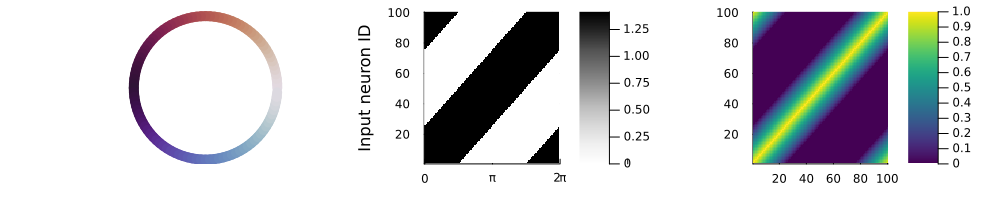

In [4]:



θ = 2π * (0:p.P-1)/p.P
center_i = Int(p.P/2)+1


x = cos.(θ)
y = sin.(θ)
colors = cgrad(:twilight, rev=true)
p0 = plot(x, y, linewidth=10, color=colors[θ ./ (2π)], aspect_ratio=:equal, legend=false,grid=false, framestyle=:none)

S = zeros(p.Ns,p.P)
for i in 1:p.Ns, n in 1:p.P
    S[i,n] = ((1≤i+n≤p.P/2) | (p.P+1≤i+n≤p.P+p.P/2)) ? sqrt(2) : 0
end
Cnz = S[:,:]
Cvec = Cnz * [cos.(θ) sin.(θ)]
Ccomp = Cvec[:,1] + Cvec[:,2]*im
Cangle = angle_correct.(angle.(Ccomp))
perm = sortperm(Cangle)
p1 = heatmap(
    θ,
    1:p.Ns, 
    Cnz[perm,:],
    colormap = :Greys,
    xticks = ([0:π:3*π;], ["0", "\\pi", "2\\pi"]),
    ylabel = "Input neuron ID"
    ) 
p2 = heatmap(cor(S),colormap = :viridis,clim=(0,1))
plot(p0, p1,p2,layout=(1,3),size=(1000,200),leftmargin=10Plots.mm,bottommargin=5Plots.mm)
#plot(p1,size=(300,240))
savefig("../figure/input_neuron_tuning.pdf")
plot!()

In [5]:
#20s
Random.seed!(1)
p.f = 0.1
p.model = :dense_normal
Nt = length(t_fixed_step(p))
σ = 2^0.
xylim = (-7,7)
Nclist = [30,100,300]
C_J = Vector{Any}(undef,length(Nclist))#zeros(p.Nc,p.P,Nt,length(Nclist))
C_h = Vector{Any}(undef,length(Nclist))#zeros(p.Nc,p.P,Nt,length(Nclist))
h_J = Vector{Any}(undef,length(Nclist))#zeros(p.Nc,p.P,Nt,length(Nclist))
h_h = Vector{Any}(undef,length(Nclist))#zeros(p.Nc,p.P,Nt,length(Nclist))
for i_Nc in 1:length(Nclist)
    p.γh = 1.; p.σh = 0.;
    p.γJ = 1.; p.σJ = σ;
    p.Nc = Nclist[i_Nc];
    ϕ(x) = x > 0 ? 1 : 0
    result = simulation_sample_trajectory(p,ϕ,S,false,N_ensemble = 0);
    h_J[i_Nc],C_J[i_Nc],corr_time,active_fraction,corr_time_ensemble,active_fraction_ensemble,corr_time_theory = result

    p.γh = 1.; p.σh = σ;
    p.γJ = 1.; p.σJ = 0.;
    p.Nc = Nclist[i_Nc];
    ϕ(x) = x > 0 ? 1 : 0
    result = simulation_sample_trajectory(p,ϕ,S,false,N_ensemble = 0);
    h_h[i_Nc],C_h[i_Nc],corr_time,active_fraction,corr_time_ensemble,active_fraction_ensemble,corr_time_theory = result
end

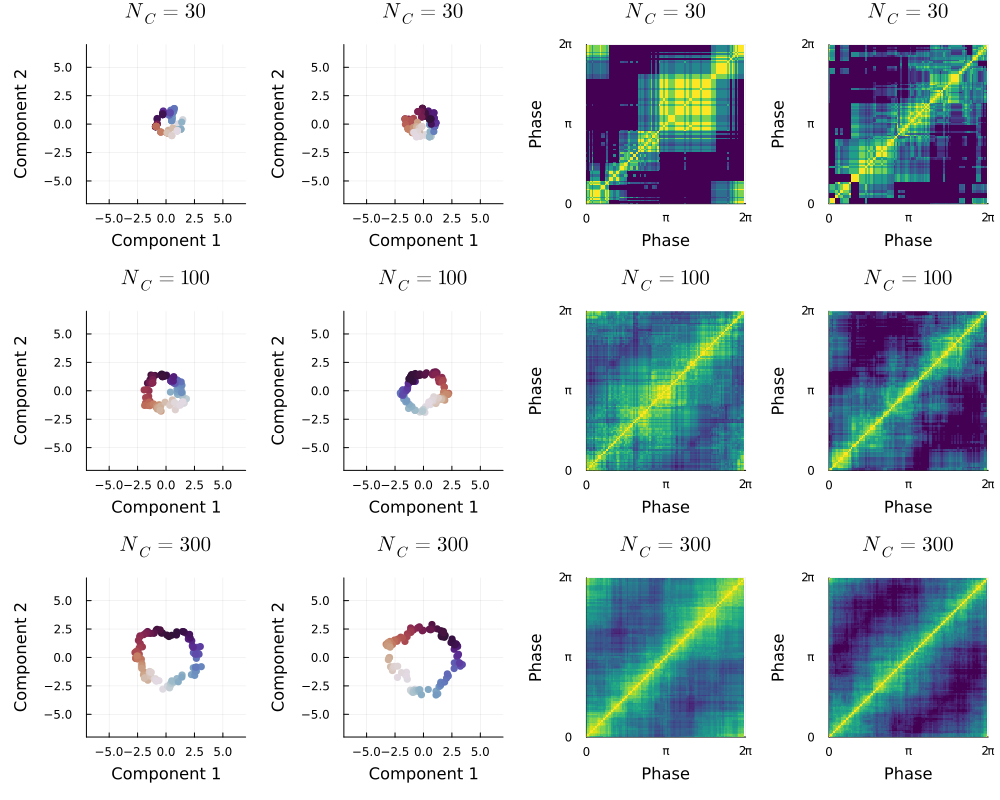

In [6]:


plot_array = Array{Any}(undef,4,length(Nclist))
colorbar=false
put_ylabel = true
put_colorbar = false
title = ["\$t=0\$","\$t=3\\tau\$","\$t=0\$","\$t=3\\tau\$"]

for i_Nc in 1:length(Nclist)
    plot_array[1,i_Nc] = plot_PCA(C_h[i_Nc][:,:,end],θ,p,colorbar,put_colorbar,"\$N_{C}=$(Nclist[i_Nc])\$",xylim) 
    plot_array[2,i_Nc] = plot_PCA(C_J[i_Nc][:,:,end],θ,p,colorbar,put_colorbar,"\$N_{C}=$(Nclist[i_Nc])\$",xylim) 
    plot_array[3,i_Nc] = plot_similarity(C_h[i_Nc][:,:,end],θ,p,colorbar,put_colorbar,put_ylabel,"\$N_{C}=$(Nclist[i_Nc])\$")
    plot_array[4,i_Nc] = plot_similarity(C_J[i_Nc][:,:,end],θ,p,colorbar,put_colorbar,put_ylabel,"\$N_{C}=$(Nclist[i_Nc])\$")
end

plot(plot_array..., layout=(length(Nclist),4),size=(1000,800),leftmargin=5Plots.mm)
savefig("../figure/tuning_Nc.pdf")
plot!()